In [ ]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils

# Preprocess images, code from github https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

# This cell is meant to be run only once to preprocess the images and save them in a new folder
# You only need to run this cell once, after the folder has been created, you can ignore it

def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
	
	return new_img
	

In [ ]:
# This cell is meant to be run only once to preprocess the images and save them in a new folder
# You only need to run this cell once, after the folder has been created, you can ignore it

training = "Training"
testing = "Testing"
training_dir = os.listdir(training)
testing_dir = os.listdir(testing)

IMG_SIZE = 64

# create training dirs
for dir in training_dir:
    save_path = 'cleaned/Training/'+ dir
    path = os.path.join(training,dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path,img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

# create testing dirs
for dir in testing_dir:
    save_path = 'cleaned/Testing/'+ dir
    path = os.path.join(testing,dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path,img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(save_path+'/'+img, new_img)

## Training and testing with different methods

In [ ]:
from sklearn.datasets import load_files
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
import os
import cv2
import numpy as np

IMG_SIZE = 64

def super_simple_load(data_dir, img_size=(IMG_SIZE, IMG_SIZE)):
    X, y = [], []
    
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if not os.path.isdir(folder_path):
            continue
            
        # each label is assigned a numeric value
        label = len(set(y))
        
        for img_file in os.listdir(folder_path):
            if img_file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(folder_path, img_file)
                img = cv2.imread(img_path, 0)  # Grayscale
                img = cv2.resize(img, img_size).flatten() / 255.0
                
                X.append(img)
                y.append(label)
    
    return np.array(X), np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split

# load the data and split them into train, validation and test sets
X_train_full, y_train_full = super_simple_load("training/")
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    random_state=20,
    stratify=y_train_full
)
X_test, y_test = super_simple_load("testing/")


(1311, 4096)

In [41]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (4569, 4096)
X_val shape: (1143, 4096)
X_test shape: (1311, 4096)


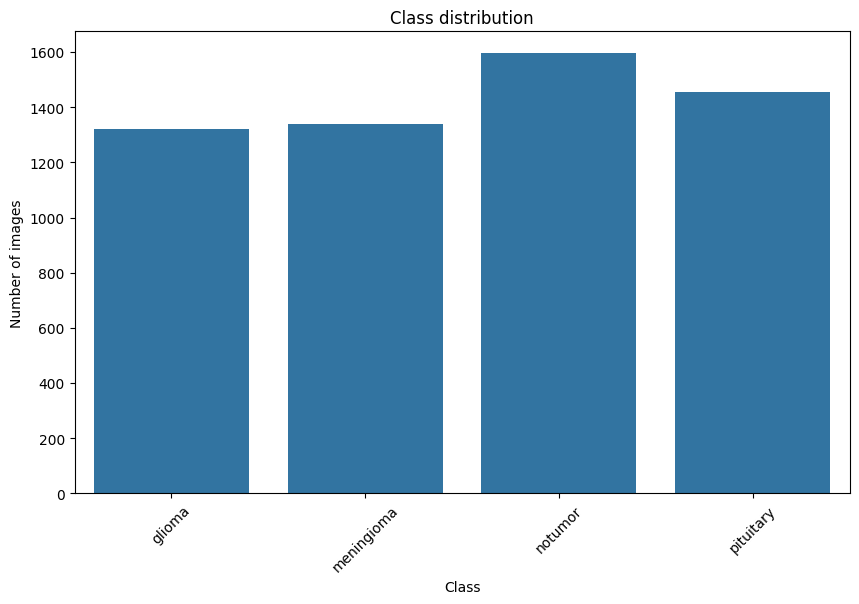

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize class distribution
classes = ["glioma", "meningioma", "notumor", "pituitary"]
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_full)
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.xticks(range(len(classes)), classes, rotation=45)
plt.show()


### Logistic Regression

Log loss: 0.39299645801697014
Training accuracy: 0.9740896358543417
Validation accuracy: 0.8722659667541557
Test accuracy: 0.8848207475209764


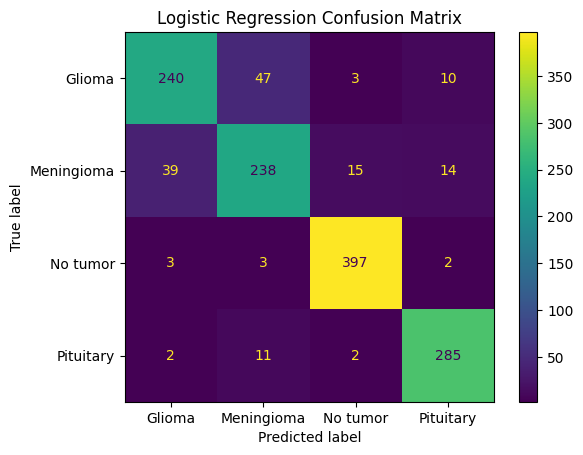

In [ ]:
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model = LogisticRegression(multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

# Get probability predictions instead of class predictions for log_loss
y_pred_proba = model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)

train_accuracy = model.score(X_train_full, y_train_full)
val_accuracy = model.score(X_val, y_val)
test_accuracy = model.score(X_test, y_test)

print(f"Log loss: {loss}")
print(f"Training accuracy: {train_accuracy}")
print(f"Validation accuracy: {val_accuracy}")
print(f"Test accuracy: {test_accuracy}")

# Also create confusion matrix for visualization
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Glioma", "Meningioma", "No tumor", "Pituitary"])
disp.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()



SVC accuracy: 0.8993135011441648


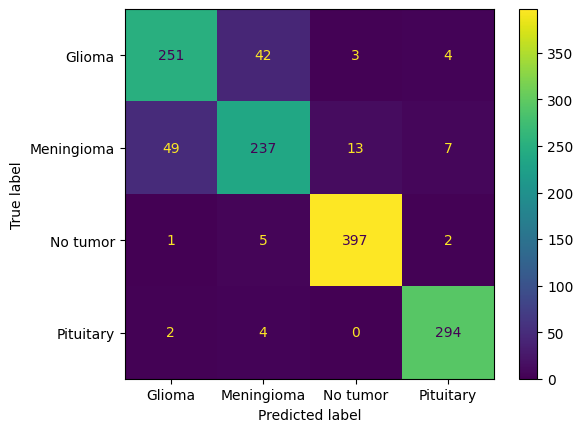

In [52]:
# train model
svc_model = SVC(kernel="linear").fit(X_train, y_train)
svc_y_pred = svc_model.predict(X_test)
print(f"SVC accuracy: {svc_model.score(X_test, y_test)}")

# confusion matrix
svc_cm = confusion_matrix(y_test, svc_y_pred)
svc_disp = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=["Glioma", "Meningioma", "No tumor", "Pituitary"])
svc_disp.plot()

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

knn = KNeighborsClassifier(n_neighbors=4)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
knn.fit(X_train_scaled, y_train)

accuracy = knn.score(X_test_scaled, y_test)
print(f"Accuracy: {accuracy}")

